In [1]:

from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted



In [14]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    df.drop("Unnamed: 0", axis = 1, inplace = True)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Split place with parent names
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop("place_with_parent_names", axis=1, inplace=True)

    

    return df

In [16]:
files = glob("C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires *.csv")
files

['C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 1.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 2.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 3.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 4.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 5.csv']

In [17]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

In [18]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)
    


In [19]:
type(frames[0])

pandas.core.frame.DataFrame

In [20]:
frames[4].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
3,sell,apartment,112000.0,USD,1698188.80,112000.0,NaN,60.0,NaN,1866.666667,1.0,2.0,NaN,http://belgrano.properati.com.ar/116pr_venta_d...,-34.564676,-58.455720,Belgrano
9,sell,apartment,76500.0,USD,1159923.60,76500.0,0.0,36.0,NaN,2125.000000,NaN,2.0,1000.0,http://caballito.properati.com.ar/12ksf_venta_...,-34.618830,-58.437779,Caballito
18,sell,apartment,90000.0,USD,1364616.00,90000.0,100.0,100.0,900.000000,900.000000,NaN,3.0,NaN,http://belgrano.properati.com.ar/zouu_venta_de...,-34.577168,-58.538654,Belgrano
20,sell,apartment,159900.0,USD,2424467.76,159900.0,82.0,77.0,1950.000000,2076.623377,NaN,3.0,NaN,http://colegiales.properati.com.ar/zpcd_venta_...,-34.571526,-58.455637,Colegiales
21,sell,apartment,123875.0,USD,1878242.30,123875.0,79.0,50.0,1568.037975,2477.500000,NaN,2.0,NaN,http://colegiales.properati.com.ar/12sbf_venta...,-34.578688,-58.457358,Colegiales


In [13]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

In [21]:
df = pd.concat(frames, ignore_index=True)
df.shape

(6582, 17)

In [22]:
# Check your work
assert len(df) == 6582, f"`df` is the wrong size: {len(df)}."

In [23]:
# Check your work
assert df.shape == (6582, 17), f"`df` is the wrong size: {df.shape}."
assert (
    "place_with_parent_names" not in df
), 'Remember to remove the `"place_with_parent_names"` column.'

In [24]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [25]:
# Check your work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

In [26]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458527
Baseline MAE: 44860.10834274134


In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Chacarita'

In [28]:
X_train.head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constituci�n
4,Once


In [29]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constituci�n,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronom�a,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Check your work
assert XT_train.shape == (6582, 57), f"`XT_train` is the wrong shape: {XT_train.shape}"

In [31]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    #LinearRegression()
    Ridge() 
    #for test
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [32]:
# Check your work
check_is_fitted(model[-1])

In [33]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [34]:
X_test = pd.read_csv("C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\lab 3 features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

In [35]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [36]:
# Check your work
assert isinstance(
    intercept, float
), f"`intercept` should be a `float`, not {type(intercept)}."
assert isinstance(
    coefficients, np.ndarray
), f"`coefficients` should be a `float`, not {type(coefficients)}."
assert coefficients.shape == (
    57,
), f"`coefficients` is wrong shape: {coefficients.shape}."

In [38]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita', 'neighborhood_Villa Luro', 'neighborhood_Caballito', 'neighborhood_Constituci�n', 'neighborhood_Once']


In [39]:
# Check your work
assert isinstance(
    feature_names, list
), f"`features` should be a `list`, not {type(features)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

In [40]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constituci�n   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [41]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")
    

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constituci�n)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nu�ez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

In [42]:
# Check your work
assert isinstance(
    model[-1], Ridge
), "Did you retrain your model using a `Ridge` predictor?"

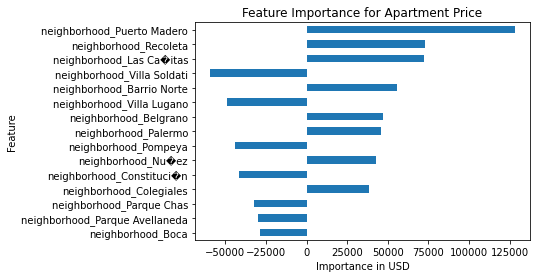

In [43]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance in USD")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");
